In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm # 진행상황 뷰 패키지
from sklearn.utils import class_weight, shuffle

from keras import applications
from keras import optimizers
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
!pwd #아나콘다 가상환경의 디텍토리를 확인.

/home/ec2-user/SageMaker/JwsPortfolio/CNN Model Project


In [3]:
!conda env list # 아나콘다 가상환경의 패키지 목록 조회.

# conda environments:
#
base                     /home/ec2-user/anaconda3
JupyterSystemEnv         /home/ec2-user/anaconda3/envs/JupyterSystemEnv
R                        /home/ec2-user/anaconda3/envs/R
amazonei_mxnet_p27       /home/ec2-user/anaconda3/envs/amazonei_mxnet_p27
amazonei_mxnet_p36       /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36
amazonei_tensorflow_p27     /home/ec2-user/anaconda3/envs/amazonei_tensorflow_p27
amazonei_tensorflow_p36     /home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36
chainer_p27              /home/ec2-user/anaconda3/envs/chainer_p27
chainer_p36              /home/ec2-user/anaconda3/envs/chainer_p36
mxnet_p27                /home/ec2-user/anaconda3/envs/mxnet_p27
mxnet_p36                /home/ec2-user/anaconda3/envs/mxnet_p36
python2                  /home/ec2-user/anaconda3/envs/python2
python3                  /home/ec2-user/anaconda3/envs/python3
pytorch_p27              /home/ec2-user/anaconda3/envs/pytorch_p27
pytorch_p36              /ho

In [4]:
!conda list -n tensorflow_p36

# packages in environment at /home/ec2-user/anaconda3/envs/tensorflow_p36:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
absl-py                   0.8.1                     <pip>
alabaster                 0.7.10           py36h306e16b_0  
anaconda-client           1.6.14                   py36_0  
anaconda-project          0.8.2            py36h44fb852_0  
argparse                  1.4.0                     <pip>
asn1crypto                0.24.0                   py36_0  
astor                     0.8.0                     <pip>
astroid                   1.6.3                    py36_0  
astropy                   3.0.2            py36h3010b51_1  
attrs                     18.1.0                   py36_0  
Automat                   0.3.0                     <pip>
autovizwidget             0.13.1                    <pip>
awscli                    1.16.283                  <pip>
babel                     2.

In [5]:
!ls -al 

total 166000
drwxrwxr-x  6 ec2-user ec2-user      4096 Dec  8 14:27 .
drwxrwxr-x  9 ec2-user ec2-user      4096 Dec  8 08:00 ..
-rw-rw-r--  1 ec2-user ec2-user     65899 Dec  8 14:08 1.png
drwxrwxr-x  3 ec2-user ec2-user      4096 Dec  8 10:17 animals
drwxrwxr-x  3 ec2-user ec2-user      4096 Dec  8 14:08 animals10
-rw-rw-r--  1 ec2-user ec2-user    255712 Dec  8 14:08 AWS SageMaker.png
-rw-rw-r--  1 ec2-user ec2-user     14798 Dec  8 08:00 CNN Model Project 설계 파일.drawio
-rw-rw-r--  1 ec2-user ec2-user     13324 Dec  8 14:26 CNN Model Project.ipynb
-rw-rw-r--  1 ec2-user ec2-user      4186 Dec  8 14:08 CNN Model Project 설계 문서.md
-rw-rw-r--  1 ec2-user ec2-user     94542 Dec  8 08:00 CNN Model Project 설계 파일.png
-rw-rw-r--  1 ec2-user ec2-user    281514 Dec  8 14:08 GCP 1.png
drwxrwxr-x  2 ec2-user ec2-user      4096 Dec  8 14:27 .ipynb_checkpoints
drwxrwxr-x 12 ec2-user ec2-user      4096 Dec  8 10:17 raw-img
-rw-rw-r--  1 ec2-user ec2-user        72 Dec  8 14:27 Untitled.ipynb
-rw-rw-r

In [6]:
#!unzip animals10.zip

In [7]:
foldernames = os.listdir("/home/ec2-user/SageMaker/JwsPortfolio/CNN Model Project/animals/raw-img") # 폴더내에 있는 데이터를 불러오기
categories = []
files = []
i = 0
for k, folder in enumerate(foldernames):
    filenames = os.listdir("../CNN Model Project/animals/raw-img/" + folder);
    for file in filenames:
        files.append("../CNN Model Project/animals/raw-img/"  + folder + "/" + file)
        categories.append(k)
        
df = pd.DataFrame({
    'filename': files,
    'category': categories
})
train_df = pd.DataFrame(columns=['filename', 'category']) # 파일이름과 카테고리를 기준으로 정렬
for i in range(10):
    train_df = train_df.append(df[df.category == i].iloc[:500,:])

train_df.head()
train_df = train_df.reset_index(drop=True)
train_df

,filename,category
0,../CNN Model Project/animals/raw-img/cavallo/O...,0
1,../CNN Model Project/animals/raw-img/cavallo/O...,0
2,../CNN Model Project/animals/raw-img/cavallo/O...,0
3,../CNN Model Project/animals/raw-img/cavallo/O...,0
4,../CNN Model Project/animals/raw-img/cavallo/O...,0
5,../CNN Model Project/animals/raw-img/cavallo/O...,0
6,../CNN Model Project/animals/raw-img/cavallo/O...,0
7,../CNN Model Project/animals/raw-img/cavallo/O...,0
8,../CNN Model Project/animals/raw-img/cavallo/O...,0
9,../CNN Model Project/animals/raw-img/cavallo/O...,0


In [8]:
y = train_df['category']
x = train_df['filename']
y = train_df['category']

x, y = shuffle(x, y, random_state=8)

In [9]:
def centering_image(img): # 이미지의 중앙을 기준으로 정렬하여 리사이징
    size = [256,256]
    
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

images = []
with tqdm(total=len(train_df)) as pbar:
    for i, file_path in enumerate(train_df.filename.values):

        img = cv2.imread(file_path) # Read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # 학습률 상승을 위하여 색상 조정

        #resize
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #out put 224*224px 
        img = img[16:240, 16:240] # 224x224x1 모델을 생성.
        images.append(img)
        pbar.update(1)

images = np.array(images)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


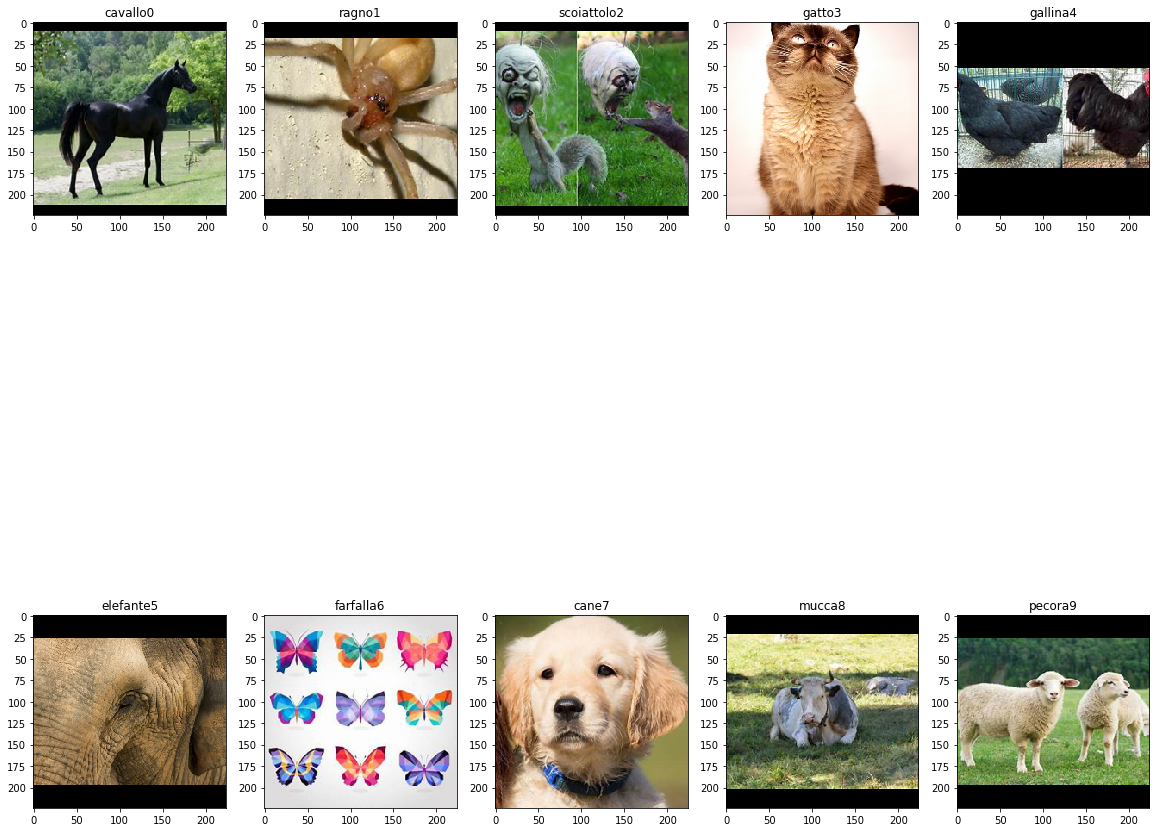

In [10]:
rows,cols = 2,5
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))
for i in range(10):
    path = train_df[train_df.category == i].values[2]
#     image = cv2.imread(path[0])/
    axes[i//cols, i%cols].set_title(path[0].split('/')[-2] + str(path[1]))
    axes[i//cols, i%cols].imshow(images[train_df[train_df.filename == path[0]].index[0]])

In [11]:
data_num = len(y)
random_index = np.random.permutation(data_num) # 랜덤함수 호출

x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]]) # x_shuffle, y_shuffle 에 244x224x1 이미지 삽입.
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle) 
y = np.array(y_shuffle)
val_split_num = int(round(0.2*len(y)))
x_train = x[val_split_num:]
y_train = y[val_split_num:]
x_test = x[:val_split_num]
y_test = y[:val_split_num]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

img_rows, img_cols, img_channel = 224, 224, 3
name_animal = []
for i in range(10):
    path = train_df[train_df.category == i].values[2]
    if path[0].split('/')[-2] == 'scoiattolo':
        name_animal.append('squirrel')
    elif path[0].split('/')[-2] == 'cavallo':
        name_animal.append('horse')
    elif path[0].split('/')[-2] == 'farfalla':
        name_animal.append('butterfly')
    elif path[0].split('/')[-2] == 'mucca':
        name_animal.append('cow')
    elif path[0].split('/')[-2] == 'gatto':
        name_animal.append('cat')
    elif path[0].split('/')[-2] == 'pecora':
        name_animal.append('sheep')
    elif path[0].split('/')[-2] == 'gallina':
        name_animal.append('chicken')
    elif path[0].split('/')[-2] == 'elefante':
        name_animal.append('elephant')
    elif path[0].split('/')[-2] == 'ragno':
        name_animal.append('spider')
    elif path[0].split('/')[-2] == 'cane':
        name_animal.append('dog')

x_train (4000, 224, 224, 3)
y_train (4000,)
x_test (1000, 224, 224, 3)
y_test (1000,)


In [12]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel)) # 224x224x3 -> 1x1x1000 까지 모델링

add_model = Sequential() # Keras Sequential 이용하여 선형으로 구성.
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(10, activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), # 모델의 학습과정을 설정.
              metrics=['accuracy'])

model.summary()








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________

In [ ]:
batch_size = 32
epochs = 5  # 1 에포크당 30분 소요로 인하여 50 -> 5 로 줄여서 학습 1500분 -> 150분으로 단축. 사용한 AWS 인스턴스 : ml.m5.xlarge(4vCPU / 16GB)
            # 결과물 작성 후 다시 50 에포크로 학습

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(x_train)


history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc')]
)

Epoch 1/5
 85/125 [===================>..........] - ETA: 8:57 - loss: 0.3304 - acc: 0.9000

In [ ]:
print("CNN: Epochs={0:d}, Train accuracy={1:.5f}, Validation accuracy={2:.5f}".format(epochs,history.history['accuracy'][epochs-1],history.history['val_accuracy'][epochs-1]))
def show_plots(history):
    """ Useful function to view plot of loss values & accuracies across the various epochs """
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['accuracy'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = history['accuracy']
    val_acc_vals = history['val_accuracy']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals
show_plots(history.history)

In [ ]:
test_images = []
j = 39 # change this to get different images
for i in range(10):
    path = train_df[train_df.category == i].values[j]
    a = images[train_df[train_df.filename == path[0]].index[0]]
    img = np.array(a)
    img = img[:, :, ::-1].copy() 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))
    img = centering_image(cv2.resize(img, dsize=tile_size))
    img = img[16:240, 16:240]
    test_images.append(img)

test_images = np.array(test_images).reshape(-1,224,224,3)
something = model.predict(test_images)
animals = name_animal
i = 0
for pred in something:
    path = train_df[train_df.category == i].values[2]
    plt.imshow(test_images[i])
    plt.show()
    print('Actual  :', animals[i])
    print('Predict :', animals[np.where(pred.max() == pred)[0][0]])
    i += 1